## CS 7650 Final Project FinBert

In [1]:
# 1. Import modules ----

import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
import torch
import torch.nn.functional as F
import yfinance as yf
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
# 2. Get Price Data from Yahoo Finance ----

def get_spx_price():
    wiki_spx = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    payload = pd.read_html(wiki_spx)
    tickers = list(payload[0].Symbol)

    res = []
    for ticker in tickers:
        yf_ticker = yf.Ticker(ticker)
        hist = yf_ticker.history(period = "max")
        df = [[ticker, date.strftime("%Y-%m-%d"), float(open), float(close)] for date, open, close in zip(hist.index, hist.Open, hist.Close)]
        res.extend(df)
    
    return res

# prices = get_spx_price()
# pickle.dump(prices, open("data/prices.pickle", 'wb'))
# prices = pickle.load(open("data/prices.pickle", 'rb'))

In [3]:
# 3. Load financial news data ----

def get_news_data():
    fpath = "./data/raw_analyst_ratings.csv"
    news = pd.read_csv(fpath)
    df = [[stock, date[:10], headline] for headline, date, stock in zip(news.headline, news.date, news.stock)]

    return df

# news = get_news_data()
# pickle.dump(news, open("data/news.pickle", 'wb'))
# news = pickle.load(open("data/news.pickle", 'rb'))

In [4]:
# 4. Combine price data and news data ----

def get_merged_data():
    prices = pickle.load(open("data/prices.pickle", 'rb'))
    news = pickle.load(open("data/news.pickle", 'rb'))

    pd_prices = pd.DataFrame(prices, columns = ["ticker", "date", "open", "close"])
    pd_news = pd.DataFrame(news, columns = ["ticker", "date", "headline"])

    df = pd.merge(pd_prices, pd_news, how = "inner", left_on = ["ticker", "date"], right_on = ["ticker", "date"])

    return df

# df = get_merged_data()
# pickle.dump(df, open("data/combined.pickle", 'wb'))
# df = pickle.load(open("data/combined.pickle", 'rb'))
# df = df[["2019" in x for x in df["date"]]]
# df = df.reset_index(drop = True)
# print(df.shape)
# df.head()

In [5]:
# 6. Get the predictions ----
def get_data():

    # 5. Load Model ----

    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

    res = []
    for i in range(0, len(df), 100):
        headlines_list = list(df.headline)[i:min(i + 100, len(df))]

        inputs = tokenizer(headlines_list, padding = True, truncation = True, return_tensors = 'pt')
        outputs = model(**inputs)
        predictions = F.softmax(outputs.logits, dim = -1)

        positive = predictions[:, 0].tolist()
        negative = predictions[:, 1].tolist()
        neutral = predictions[:, 2].tolist()

        dat = [[x, y, z] for x, y, z in zip(positive, negative, neutral)]
        res.extend(dat)

    return res

# scores = get_data()
# pickle.dump(scores, open("data/scores.pickle", 'wb'))
scores = pickle.load(open("data/scores.pickle", 'rb'))

In [6]:
# 7. combine all data together
df = pickle.load(open("data/combined.pickle", 'rb'))
df = df[["2019" in x for x in df["date"]]]
df = df.reset_index(drop = True)

df["positive"] = [x[0] for x in scores]
df["negative"] = [x[1] for x in scores]
df["neutral"] = [x[2] for x in scores]
df["label"] = df[["positive", "negative", "neutral"]].idxmax(axis = 1)
df["label_index"] = 0

conditions = [
    (df['label'] == "positive"),
    (df['label'] == "neutral"),
    (df['label'] == "negative"),
]
df['label_index'] = np.select(conditions, [1, 0, -1])
df["return"] = df["close"] / df["open"] - 1
df.head()
df

,ticker,date,open,close,headline,positive,negative,neutral,label,label_index,return
0,MMM,2019-01-23,172.466867,172.162445,"Geopolitics Aside, How About Those Earnings? I...",0.086234,0.034777,0.878990,neutral,0,-0.001765
1,MMM,2019-01-29,174.597749,176.334686,"Apple Today, Powell Tomorrow: Busy Earnings An...",0.030682,0.615620,0.353698,negative,-1,0.009948
2,MMM,2019-01-29,174.597749,176.334686,From 3M Conference Call: Co. Says Some Of The ...,0.251566,0.639922,0.108511,negative,-1,0.009948
3,MMM,2019-01-29,174.597749,176.334686,3M shares are trading higher after the company...,0.954430,0.025813,0.019758,positive,1,0.009948
4,MMM,2019-01-29,174.597749,176.334686,3M Cuts FY19 EPS Guidance From $10.60-$11.05 T...,0.019528,0.948419,0.032053,negative,-1,0.009948
...,...,...,...,...,...,...,...,...,...,...,...
41230,ZTS,2019-11-22,118.669343,118.078011,"Zoetis Reports Purchase Of ZNLabs, No Terms Di...",0.031328,0.019045,0.949628,neutral,0,-0.004983
41231,ZTS,2019-12-02,119.122696,118.176575,Shares of several healthcare stocks are tradin...,0.009223,0.972068,0.018709,negative,-1,-0.007942
41232,ZTS,2019-12-11,121.418984,121.773781,Zoetis Raises Quarterly Dividend From $0.164 T...,0.781536,0.093841,0.124624,positive,1,0.002922
41233,ZTS,2019-12-20,127.509650,130.761932,Stocks That Hit 52-Week Highs On Friday,0.211447,0.082010,0.706543,neutral,0,0.025506


In [9]:
len(set(df['ticker']))

384

In [10]:
# 8. Analyze Overall Finbert Correlation - 1 Day return with heading news
print(df[["positive", "negative", "neutral", "return"]].corr()["return"])
print(df[["label_index", "return"]].corr()["return"])
print("Positive Prob: ", sum(df["label_index"] == 1) / len(df))
print("Negative Prob: ", sum(df["label_index"] == -1) / len(df))
print("Neutral Prob: ", sum(df["label_index"] == 0) / len(df))

positive    0.141394
negative   -0.163959
neutral     0.014259
return      1.000000
Name: return, dtype: float64
label_index    0.158736
return         1.000000
Name: return, dtype: float64
Positive Prob:  0.3159209409482236
Negative Prob:  0.25391051291378686
Neutral Prob:  0.43016854613798955


In [11]:
# 9. Trainning Prepration - Group by
dfg = df.groupby(["ticker", "date"], as_index = False).mean()
dfg["label"] = dfg[["positive", "negative", "neutral"]].idxmax(axis = 1)
conditions = [
    (dfg['label'] == "positive"),
    (dfg['label'] == "neutral"),
    (dfg['label'] == "negative"),
]
dfg['label_index'] = np.select(conditions, [1, 0, -1])
dfg["return"] = dfg["close"] / dfg["open"] - 1
dfg.head()

,ticker,date,open,close,positive,negative,neutral,label_index,return,label
0,A,2019-01-03,64.005265,61.797852,0.288399,0.012152,0.699449,0,-0.034488,neutral
1,A,2019-01-29,71.985169,71.848427,0.188758,0.083741,0.727501,0,-0.001900,neutral
2,A,2019-02-12,75.013034,75.276749,0.459587,0.066880,0.473533,0,0.003516,neutral
3,A,2019-02-14,75.208397,75.227928,0.023959,0.049990,0.926050,0,0.000260,neutral
4,A,2019-02-20,75.726068,76.732101,0.516603,0.080887,0.402509,1,0.013285,positive


In [12]:
# 10. Stats after groupby
print(dfg[["positive", "negative", "neutral", "return"]].corr()["return"])
print(dfg[["label_index", "return"]].corr()["return"])
print("Positive Prob: ", sum(dfg["label_index"] == 1) / len(dfg))
print("Negative Prob: ", sum(dfg["label_index"] == -1) / len(dfg))
print("Neutral Prob: ", sum(dfg["label_index"] == 0) / len(dfg))

positive    0.243941
negative   -0.276898
neutral     0.030571
return      1.000000
Name: return, dtype: float64
label_index    0.27585
return         1.00000
Name: return, dtype: float64
Positive Prob:  0.31425623894674787
Negative Prob:  0.23398506582825704
Neutral Prob:  0.45175869522499507


In [13]:
# 11. Start Training - Predictions on Close

## Split the trainning and testing data

X = dfg[['neutral', 'positive', 'negative', 'open']]
Y = dfg['close']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)


In [14]:
## Build a DNN Model

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

def build_and_compile_model(norm):
    model = Sequential()
    model.add(norm)
    model.add(Dense(256, activation = lambda x : tf.nn.leaky_relu(x, alpha = 0.01),  input_dim = 3))
    model.add(Dense(256, activation = lambda x : tf.nn.leaky_relu(x, alpha = 0.01)))
    model.add(Dense(1, activation = "linear"))
    model.compile(loss = 'mean_squared_error', optimizer = Adam(lr=1e-3, decay=1e-3 / 200))
    return model

dnn_model = build_and_compile_model(normalizer)

dnn_model.summary()

2022-05-01 16:29:28.367222: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               1280      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 67,338
Trainable params: 67,329
Non-trainable params: 9
_________________________________________________________________


/Users/liangyu/opt/miniconda3/envs/cv_proj5/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
## Fit the DNN model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
history = dnn_model.fit(X_train, Y_train, validation_split = 0.2, epochs = 20, batch_size=100, verbose=1, callbacks=[es])

Epoch 1/20
147/147 [==============================] - 1s 2ms/step - loss: 37371.0273 - val_loss: 5497.3154
Epoch 2/20
147/147 [==============================] - 0s 1ms/step - loss: 735.5359 - val_loss: 100.1172
Epoch 3/20
147/147 [==============================] - 0s 1ms/step - loss: 60.2693 - val_loss: 35.8866
Epoch 4/20
147/147 [==============================] - 0s 1ms/step - loss: 25.0313 - val_loss: 19.6199
Epoch 5/20
147/147 [==============================] - 0s 1ms/step - loss: 16.4179 - val_loss: 16.0695
Epoch 6/20
147/147 [==============================] - 0s 1ms/step - loss: 14.7034 - val_loss: 15.3886
Epoch 7/20
147/147 [==============================] - 0s 1ms/step - loss: 14.4066 - val_loss: 17.6569
Epoch 8/20
147/147 [==============================] - 0s 1ms/step - loss: 14.7008 - val_loss: 17.2882
Epoch 9/20
147/147 [==============================] - 0s 1ms/step - loss: 15.0901 - val_loss: 20.8009
Epoch 10/20
147/147 [==============================] - 0s 1ms/step - loss: 

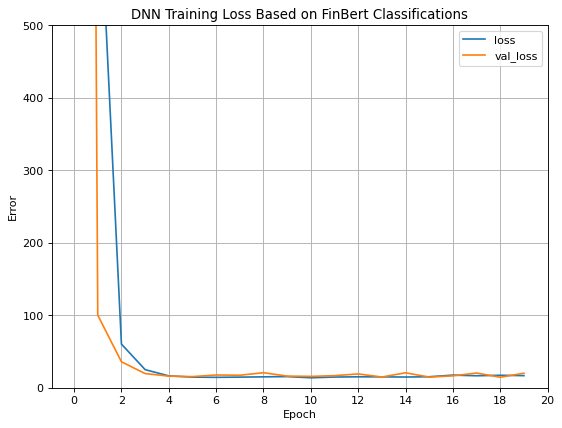

In [16]:
# 12. Plot the Loss History
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 500])
plt.xticks(np.array(range(11)) * 2)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title("DNN Training Loss Based on FinBert Classifications")
plt.legend()
plt.grid(True, which = 'major')

64/64 [==============================] - 0s 724us/step - loss: 17.1006
17.10059356689453


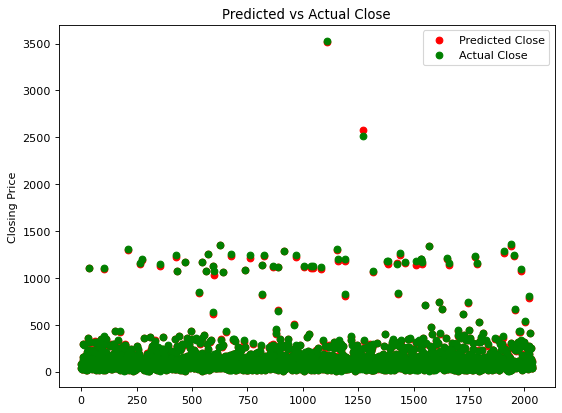

In [17]:
# 13. Plot Actual Predictions

preds = dnn_model.predict(X_test)
print(dnn_model.evaluate(X_test, Y_test, verbose=1))

rcParams['figure.figsize'] = 20, 10
X = [i for i in range(len(preds))]
  
# Assign variables to the y axis part of the curve
y = preds
z = Y_test

plt.figure(figsize=(8, 6), dpi=80)

# Plotting both the curves simultaneously
plt.scatter(X, y, color='r', label='Predicted Close')
plt.scatter(X, z, color='g', label='Actual Close')
  
# Naming the x-axis, y-axis and the whole graph
plt.ylabel("Closing Price")
plt.title("Predicted vs Actual Close")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

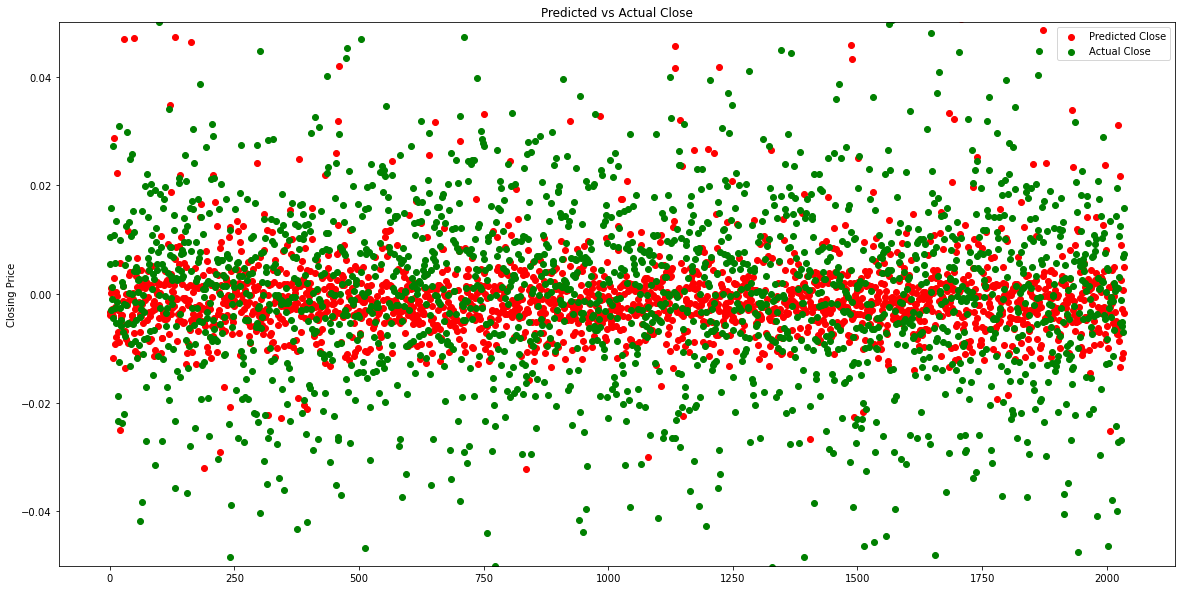

In [85]:
pred_return = np.array(preds) / np.array(X_test[["open"]]) - 1
actual_return = np.array(np.matrix(Y_test).reshape(len(Y_test), 1)) / np.array(X_test[["open"]]) - 1

# Plotting both the curves simultaneously
plt.scatter(range(len(pred_return)), pred_return, color='r', label='Predicted Close')
plt.scatter(range(len(actual_return)), actual_return, color='g', label='Actual Close')

plt.ylim([-0.05, 0.05])

# Naming the x-axis, y-axis and the whole graph
plt.ylabel("Closing Price")
plt.title("Predicted vs Actual Close")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [86]:
# Final: Some stats
p_same_directon = np.sum(actual_return * pred_return >= 0) / len(actual_return)
p_error_1 = np.sum(abs(actual_return - pred_return) <= 0.01) / len(actual_return)
p_error_2 = np.sum(abs(actual_return - pred_return) <= 0.02) / len(actual_return)
p_error_5 = np.sum(abs(actual_return - pred_return) <= 0.05) / len(actual_return)

print(p_same_directon, p_error_1, p_error_2, p_error_5)

0.5137524557956779 0.48379174852652257 0.7657170923379175 0.956286836935167


In [96]:
comp = np.array(preds) / np.array(np.matrix(Y_test).reshape(len(Y_test), 1)) - 1

p_same_directon = np.sum(comp >= 0) / len(comp)
p_error_1 = np.sum(abs(comp) <= 0.01) / len(comp)
p_error_2 = np.sum(abs(comp) <= 0.02) / len(comp)
p_error_5 = np.sum(abs(comp) <= 0.05) / len(comp)

print(p_same_directon, p_error_1, p_error_2, p_error_5)

0.44155206286836934 0.48280943025540274 0.7657170923379175 0.9572691552062869
